# Comparison


In [1]:
import pandas as pd
import numpy as np
import os
import pickle

pd.set_option("display.max_columns", None)

In [2]:
from scripts.params import get_params
from scripts.aux_functions import get_all_results_matching, subset_of_columns, clean_modelname

params = get_params()

In [3]:
from scripts.epftoolbox_dm_gw import DM, plot_multivariate_DM_test, GW, plot_multivariate_GW_test

In [4]:
dataroute = params["dataroute"]
resultsroute = params["resultsroute"]
dumproute = params["dumproute"]
graphsroute = params["graphsroute"]
dmroute=params["dmroute"]
gwroute=params["gwroute"]

In [5]:
start_test = params["start_test"]
local_suffix = params["local_suffix"]

In [6]:
name = f'finaldf_test_{params["tablename"]}.pickle'
filename = os.path.join(dataroute, name)
with open(filename, "rb") as handle:
    df_test = pickle.load(handle)
    
df_test.index=pd.to_datetime(df_test.index.copy())

In [7]:
all_forecasts = get_all_results_matching(params["resultsroute"], ["best_forecasts"])
all_residuals = get_all_results_matching(params["resultsroute"], ["best_residuals"])

{'GARCH_MX_^MXX_aic_best_forecasts.pickle': '..\\results\\MX_^MXX\\GARCH_MX_^MXX_aic_best_forecasts.pickle', 'GARCH_MX_^MXX_bic_best_forecasts.pickle': '..\\results\\MX_^MXX\\GARCH_MX_^MXX_bic_best_forecasts.pickle', 'HMM_multiv_MX_^MXX_aic_best_forecasts.pickle': '..\\results\\MX_^MXX\\HMM_multiv_MX_^MXX_aic_best_forecasts.pickle', 'HMM_multiv_MX_^MXX_bic_best_forecasts.pickle': '..\\results\\MX_^MXX\\HMM_multiv_MX_^MXX_bic_best_forecasts.pickle', 'HMM_univ_MX_^MXX_aic_best_forecasts.pickle': '..\\results\\MX_^MXX\\HMM_univ_MX_^MXX_aic_best_forecasts.pickle', 'HMM_univ_MX_^MXX_bic_best_forecasts.pickle': '..\\results\\MX_^MXX\\HMM_univ_MX_^MXX_bic_best_forecasts.pickle', 'HMM_with_vol_MX_^MXX_aic_best_forecasts.pickle': '..\\results\\MX_^MXX\\HMM_with_vol_MX_^MXX_aic_best_forecasts.pickle', 'HMM_with_vol_MX_^MXX_bic_best_forecasts.pickle': '..\\results\\MX_^MXX\\HMM_with_vol_MX_^MXX_bic_best_forecasts.pickle', 'VAR_multiv_MX_^MXX_aic_best_forecasts.pickle': '..\\results\\MX_^MXX\\VAR_

In [8]:
def get_only_log_rets(dict_with_dfs: dict, stock: str):
    if type(dict_with_dfs[stock]) == pd.Series:
        # univariate models are saved as series
        df = pd.DataFrame(dict_with_dfs[stock])

    else:
        try:
            # multivariate models are saved as dataframes
            df = pd.DataFrame(dict_with_dfs[stock][f"{stock}_log_rets"])
        except:  # TODO: SACAR ESTO! Es un chanchullo pq hay algunas que son guardadas como None
            pass
    return df

In [9]:
def create_df_from_results_dict(results_dict:dict, substring_to_replace:str):
    created_df = pd.DataFrame()

    for name, dir in results_dict.items():
        dict_with_dfs = pd.read_pickle(dir)
        print(name)

        for stock in dict_with_dfs.keys():
            df = get_only_log_rets(dict_with_dfs, stock)

            modelname = clean_modelname(name, substring_to_replace, tablename=params["tablename"])

            df.columns = [modelname + "_" + stock]

            created_df = pd.merge(
                created_df, df, left_index=True, right_index=True, how="outer"
            )

    created_df.index = pd.to_datetime(created_df.index)
    created_df = created_df[created_df.index > start_test]
    return created_df

In [10]:
forecasts_df = create_df_from_results_dict(all_forecasts, "forecasts")

GARCH_MX_^MXX_aic_best_forecasts.pickle
GARCH_MX_^MXX_bic_best_forecasts.pickle
HMM_multiv_MX_^MXX_aic_best_forecasts.pickle
HMM_multiv_MX_^MXX_bic_best_forecasts.pickle
HMM_univ_MX_^MXX_aic_best_forecasts.pickle
HMM_univ_MX_^MXX_bic_best_forecasts.pickle
HMM_with_vol_MX_^MXX_aic_best_forecasts.pickle
HMM_with_vol_MX_^MXX_bic_best_forecasts.pickle
VAR_multiv_MX_^MXX_aic_best_forecasts.pickle
VAR_multiv_MX_^MXX_bic_best_forecasts.pickle
VAR_with_vol_MX_^MXX_aic_best_forecasts.pickle
VAR_with_vol_MX_^MXX_bic_best_forecasts.pickle


In [11]:
forecasts_df = pd.concat([forecasts_df, subset_of_columns(df_test, "log_rets")])

In [12]:
residual_df = create_df_from_results_dict(all_residuals, "residuals")

GARCH_MX_^MXX_aic_best_residuals.pickle
GARCH_MX_^MXX_bic_best_residuals.pickle
HMM_multiv_MX_^MXX_aic_best_residuals.pickle
HMM_multiv_MX_^MXX_bic_best_residuals.pickle
HMM_univ_MX_^MXX_aic_best_residuals.pickle
HMM_univ_MX_^MXX_bic_best_residuals.pickle
HMM_with_vol_MX_^MXX_aic_best_residuals.pickle
HMM_with_vol_MX_^MXX_bic_best_residuals.pickle
VAR_multiv_MX_^MXX_aic_best_residuals.pickle
VAR_multiv_MX_^MXX_bic_best_residuals.pickle
VAR_with_vol_MX_^MXX_aic_best_residuals.pickle
VAR_with_vol_MX_^MXX_bic_best_residuals.pickle


In [13]:
lower_date=pd.to_datetime(params["start_test"])+pd.Timedelta(days=1)
higher_date=pd.to_datetime(params["end_test"])-pd.Timedelta(days=1)
residual_df=residual_df[lower_date:higher_date].copy()
df_test = df_test[lower_date:higher_date].copy()
residual_df.head()

,GARCH_aic_MXX_USD,GARCH_aic_^MXX,GARCH_aic_WALMEX.MX,GARCH_aic_WMMVY,GARCH_aic_GFNORTEO.MX,GARCH_aic_GBOOY,GARCH_aic_FEMSAUBD.MX,GARCH_aic_FMX,GARCH_aic_CEMEXCPO.MX,GARCH_aic_CX,GARCH_bic_MXX_USD,GARCH_bic_^MXX,GARCH_bic_WALMEX.MX,GARCH_bic_WMMVY,GARCH_bic_GFNORTEO.MX,GARCH_bic_GBOOY,GARCH_bic_FEMSAUBD.MX,GARCH_bic_FMX,GARCH_bic_CEMEXCPO.MX,GARCH_bic_CX,HMM_multiv_aic_MXX_USD,HMM_multiv_aic_^MXX,HMM_multiv_aic_WALMEX.MX,HMM_multiv_aic_WMMVY,HMM_multiv_aic_GFNORTEO.MX,HMM_multiv_aic_GBOOY,HMM_multiv_aic_FEMSAUBD.MX,HMM_multiv_aic_FMX,HMM_multiv_aic_CEMEXCPO.MX,HMM_multiv_aic_CX,HMM_multiv_bic_MXX_USD,HMM_multiv_bic_^MXX,HMM_multiv_bic_WALMEX.MX,HMM_multiv_bic_WMMVY,HMM_multiv_bic_GFNORTEO.MX,HMM_multiv_bic_GBOOY,HMM_multiv_bic_FEMSAUBD.MX,HMM_multiv_bic_FMX,HMM_multiv_bic_CEMEXCPO.MX,HMM_multiv_bic_CX,HMM_univ_aic_MXX_USD,HMM_univ_aic_^MXX,HMM_univ_aic_WALMEX.MX,HMM_univ_aic_WMMVY,HMM_univ_aic_GFNORTEO.MX,HMM_univ_aic_GBOOY,HMM_univ_aic_FEMSAUBD.MX,HMM_univ_aic_FMX,HMM_univ_aic_CEMEXCPO.MX,HMM_univ_aic_CX,HMM_univ_bic_MXX_USD,HMM_univ_bic_^MXX,HMM_univ_bic_WALMEX.MX,HMM_univ_bic_WMMVY,HMM_univ_bic_GFNORTEO.MX,HMM_univ_bic_GBOOY,HMM_univ_bic_FEMSAUBD.MX,HMM_univ_bic_FMX,HMM_univ_bic_CEMEXCPO.MX,HMM_univ_bic_CX,HMM_with_vol_aic_MXX_USD,HMM_with_vol_aic_^MXX,HMM_with_vol_aic_WALMEX.MX,HMM_with_vol_aic_WMMVY,HMM_with_vol_aic_GFNORTEO.MX,HMM_with_vol_aic_GBOOY,HMM_with_vol_aic_FEMSAUBD.MX,HMM_with_vol_aic_FMX,HMM_with_vol_aic_CEMEXCPO.MX,HMM_with_vol_aic_CX,HMM_with_vol_bic_MXX_USD,HMM_with_vol_bic_^MXX,HMM_with_vol_bic_WALMEX.MX,HMM_with_vol_bic_WMMVY,HMM_with_vol_bic_GFNORTEO.MX,HMM_with_vol_bic_GBOOY,HMM_with_vol_bic_FEMSAUBD.MX,HMM_with_vol_bic_FMX,HMM_with_vol_bic_CEMEXCPO.MX,HMM_with_vol_bic_CX,VAR_multiv_aic_MXX_USD,VAR_multiv_aic_^MXX,VAR_multiv_aic_WALMEX.MX,VAR_multiv_aic_WMMVY,VAR_multiv_aic_GFNORTEO.MX,VAR_multiv_aic_GBOOY,VAR_multiv_aic_FEMSAUBD.MX,VAR_multiv_aic_FMX,VAR_multiv_aic_CEMEXCPO.MX,VAR_multiv_aic_CX,VAR_multiv_bic_MXX_USD,VAR_multiv_bic_^MXX,VAR_multiv_bic_WALMEX.MX,VAR_multiv_bic_WMMVY,VAR_multiv_bic_GFNORTEO.MX,VAR_multiv_bic_GBOOY,VAR_multiv_bic_FEMSAUBD.MX,VAR_multiv_bic_FMX,VAR_multiv_bic_CEMEXCPO.MX,VAR_multiv_bic_CX,VAR_with_vol_aic_MXX_USD,VAR_with_vol_aic_^MXX,VAR_with_vol_aic_WALMEX.MX,VAR_with_vol_aic_WMMVY,VAR_with_vol_aic_GFNORTEO.MX,VAR_with_vol_aic_GBOOY,VAR_with_vol_aic_FEMSAUBD.MX,VAR_with_vol_aic_FMX,VAR_with_vol_aic_CEMEXCPO.MX,VAR_with_vol_aic_CX,VAR_with_vol_bic_MXX_USD,VAR_with_vol_bic_^MXX,VAR_with_vol_bic_WALMEX.MX,VAR_with_vol_bic_WMMVY,VAR_with_vol_bic_GFNORTEO.MX,VAR_with_vol_bic_GBOOY,VAR_with_vol_bic_FEMSAUBD.MX,VAR_with_vol_bic_FMX,VAR_with_vol_bic_CEMEXCPO.MX,VAR_with_vol_bic_CX
2023-06-01,0.005768,-0.000321,-0.008931,-0.000455,-0.006442,-0.000996,-6.416799e-03,0.005480,0.001739,0.010282,0.005685,-0.000352,2.660298,-0.000328,-0.006442,-0.001194,-0.006415,0.005484,0.001739,0.010170,0.006842,-0.000110,-0.008284,0.000145,-0.005359,0.000128,-0.005102,0.006817,0.001809,0.011234,0.007032,0.000595,-0.009292,-0.000259,-0.004361,-0.000604,-0.005421,0.006370,0.001636,0.010657,0.006298,-0.000262,-0.008785,-0.000096,-0.006209,-0.001237,-0.006600,0.005596,0.002518,0.010853,0.006654,-0.000262,-0.008785,-0.000096,-0.005882,-0.001237,-0.006600,0.005596,0.002090,0.010823,0.004840,-0.000352,-0.007947,0.000275,-0.005937,-0.001876,-0.005817,0.006145,-0.000052,0.010370,0.006498,-0.000352,-0.007949,-0.000473,-0.004129,-0.000713,-0.006281,0.004623,0.002264,0.010089,-0.013218,-0.008112,-0.019480,-0.026407,-0.032451,-0.032542,0.026956,0.025535,0.000943,-0.003739,-0.023693,-0.012686,-0.016404,-0.021568,-0.037989,-0.039829,0.028556,0.026532,-0.000514,-0.007740,-0.024960,-0.013399,-0.018156,-0.029381,-0.037038,-0.043696,0.027477,0.024768,-0.002247,-0.006199,-0.023486,-0.012595,-0.017758,-0.024151,-0.042531,-0.042590,0.029550,0.027098,-0.001875,-0.006279
2023-06-02,0.015292,0.009137,0.009946,0.011821,-0.003760,0.005749,-2.183701e-02,0.009670,0.042994,0.045195,0.015181,0.009014,0.009955,0.012668,-0.003760,

In [14]:
# estadisticos de nans
((residual_df.isna().sum(axis=0) / len(residual_df.index)) * 100).nlargest(10)

GARCH_aic_MXX_USD        0.0
GARCH_aic_^MXX           0.0
GARCH_aic_WALMEX.MX      0.0
GARCH_aic_WMMVY          0.0
GARCH_aic_GFNORTEO.MX    0.0
GARCH_aic_GBOOY          0.0
GARCH_aic_FEMSAUBD.MX    0.0
GARCH_aic_FMX            0.0
GARCH_aic_CEMEXCPO.MX    0.0
GARCH_aic_CX             0.0
dtype: float64

In [15]:
# estadisticos de nans
((forecasts_df.isna().sum(axis=0) / len(forecasts_df.index)) * 100).nlargest(10)

GARCH_aic_MXX_USD        50.636943
GARCH_aic_^MXX           50.636943
GARCH_aic_WALMEX.MX      50.636943
GARCH_aic_WMMVY          50.636943
GARCH_aic_GFNORTEO.MX    50.636943
GARCH_aic_GBOOY          50.636943
GARCH_aic_FEMSAUBD.MX    50.636943
GARCH_aic_FMX            50.636943
GARCH_aic_CEMEXCPO.MX    50.636943
GARCH_aic_CX             50.636943
dtype: float64

## Separating in different stocks

In [16]:
def separate_by_stock(df:pd.DataFrame):
     stock_dict={}

     for stock in params["tickerlist"]:
          if params["local_suffix"] in stock:
               stock_dict[stock]= subset_of_columns(residual_df, stock)
          else:
               stock_dict[stock]= subset_of_columns(residual_df, stock, params["local_suffix"])    
     
     return stock_dict      

In [17]:
forecasts_by_stock=separate_by_stock(forecasts_df)
residuals_by_stock=separate_by_stock(residual_df)

In [18]:
for df_clean, name in zip([forecasts_by_stock, residuals_by_stock], ["forecasts", "residuals"]):
    bystockname = name + "_by_stock_" + params["tablename"] + ".pickle"
    with open(os.path.join(resultsroute, bystockname), "wb") as handle:
        pickle.dump(df_clean, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [19]:
def delete_in_column_names(df:pd.DataFrame, string:str):
    new_cols=[]
    for col in df.columns:
        col=col.replace(string, "")
        new_cols.append(col)
    df=df.set_axis(labels=new_cols, axis=1)
    return df

^MXX


c:\Users\alfredo.sampron\Documents\GitHub\regime-switching-hmm\notebooks\scripts\epftoolbox_dm_gw.py:108: RuntimeWarning: divide by zero encountered in scalar divide
  DM_stat = mean_d / np.sqrt((1 / N) * var_d)
c:\Users\alfredo.sampron\Documents\GitHub\regime-switching-hmm\notebooks\scripts\epftoolbox_dm_gw.py:108: RuntimeWarning: invalid value encountered in scalar divide
  DM_stat = mean_d / np.sqrt((1 / N) * var_d)


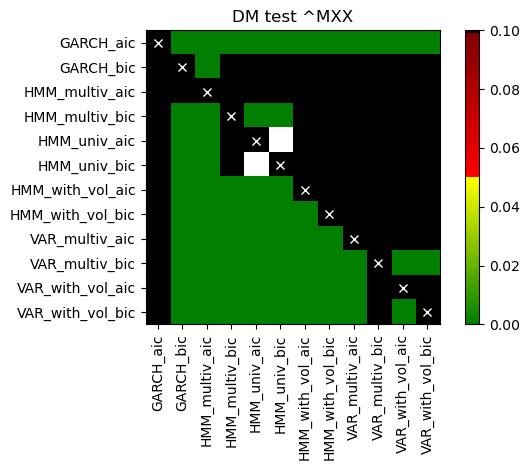

WALMEX.MX


c:\Users\alfredo.sampron\Documents\GitHub\regime-switching-hmm\notebooks\scripts\epftoolbox_dm_gw.py:108: RuntimeWarning: divide by zero encountered in scalar divide
  DM_stat = mean_d / np.sqrt((1 / N) * var_d)
c:\Users\alfredo.sampron\Documents\GitHub\regime-switching-hmm\notebooks\scripts\epftoolbox_dm_gw.py:108: RuntimeWarning: invalid value encountered in scalar divide
  DM_stat = mean_d / np.sqrt((1 / N) * var_d)


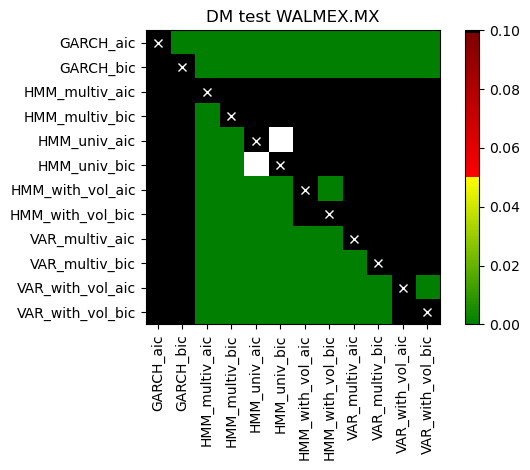

WMMVY


c:\Users\alfredo.sampron\Documents\GitHub\regime-switching-hmm\notebooks\scripts\epftoolbox_dm_gw.py:108: RuntimeWarning: divide by zero encountered in scalar divide
  DM_stat = mean_d / np.sqrt((1 / N) * var_d)
c:\Users\alfredo.sampron\Documents\GitHub\regime-switching-hmm\notebooks\scripts\epftoolbox_dm_gw.py:108: RuntimeWarning: invalid value encountered in scalar divide
  DM_stat = mean_d / np.sqrt((1 / N) * var_d)


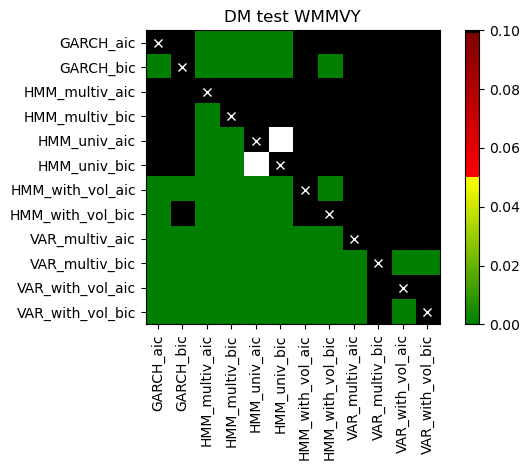

GFNORTEO.MX


c:\Users\alfredo.sampron\Documents\GitHub\regime-switching-hmm\notebooks\scripts\epftoolbox_dm_gw.py:108: RuntimeWarning: invalid value encountered in scalar divide
  DM_stat = mean_d / np.sqrt((1 / N) * var_d)
c:\Users\alfredo.sampron\Documents\GitHub\regime-switching-hmm\notebooks\scripts\epftoolbox_dm_gw.py:108: RuntimeWarning: divide by zero encountered in scalar divide
  DM_stat = mean_d / np.sqrt((1 / N) * var_d)


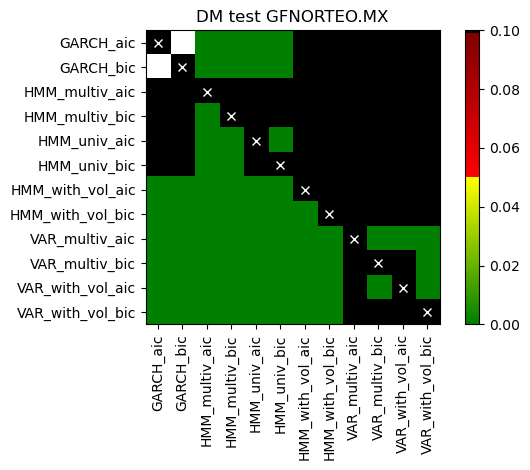

GBOOY


c:\Users\alfredo.sampron\Documents\GitHub\regime-switching-hmm\notebooks\scripts\epftoolbox_dm_gw.py:108: RuntimeWarning: divide by zero encountered in scalar divide
  DM_stat = mean_d / np.sqrt((1 / N) * var_d)
c:\Users\alfredo.sampron\Documents\GitHub\regime-switching-hmm\notebooks\scripts\epftoolbox_dm_gw.py:108: RuntimeWarning: invalid value encountered in scalar divide
  DM_stat = mean_d / np.sqrt((1 / N) * var_d)


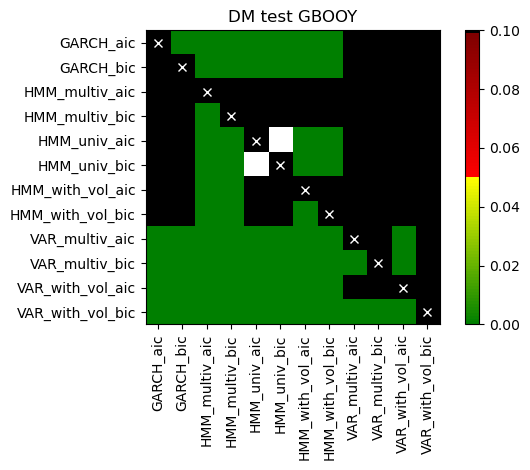

FEMSAUBD.MX


c:\Users\alfredo.sampron\Documents\GitHub\regime-switching-hmm\notebooks\scripts\epftoolbox_dm_gw.py:108: RuntimeWarning: divide by zero encountered in scalar divide
  DM_stat = mean_d / np.sqrt((1 / N) * var_d)
c:\Users\alfredo.sampron\Documents\GitHub\regime-switching-hmm\notebooks\scripts\epftoolbox_dm_gw.py:108: RuntimeWarning: invalid value encountered in scalar divide
  DM_stat = mean_d / np.sqrt((1 / N) * var_d)


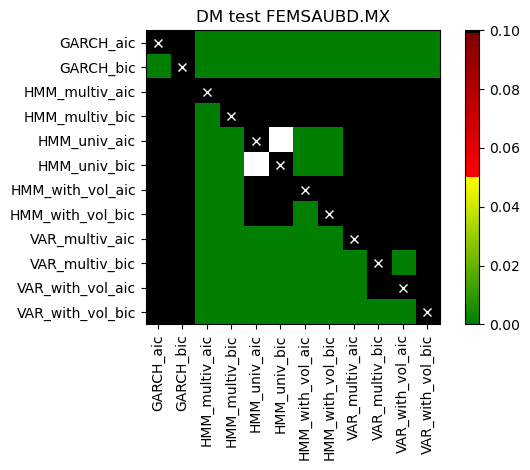

FMX


c:\Users\alfredo.sampron\Documents\GitHub\regime-switching-hmm\notebooks\scripts\epftoolbox_dm_gw.py:108: RuntimeWarning: divide by zero encountered in scalar divide
  DM_stat = mean_d / np.sqrt((1 / N) * var_d)
c:\Users\alfredo.sampron\Documents\GitHub\regime-switching-hmm\notebooks\scripts\epftoolbox_dm_gw.py:108: RuntimeWarning: invalid value encountered in scalar divide
  DM_stat = mean_d / np.sqrt((1 / N) * var_d)


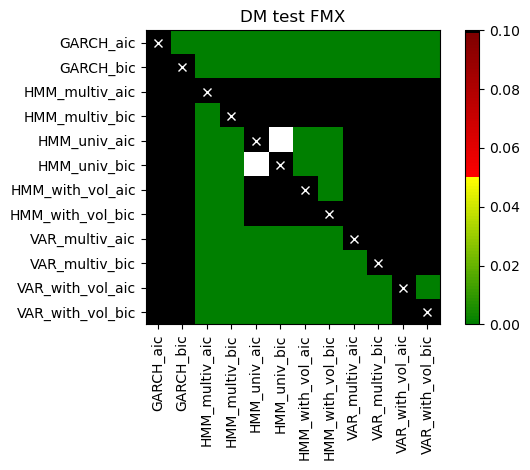

CEMEXCPO.MX


c:\Users\alfredo.sampron\Documents\GitHub\regime-switching-hmm\notebooks\scripts\epftoolbox_dm_gw.py:108: RuntimeWarning: divide by zero encountered in scalar divide
  DM_stat = mean_d / np.sqrt((1 / N) * var_d)


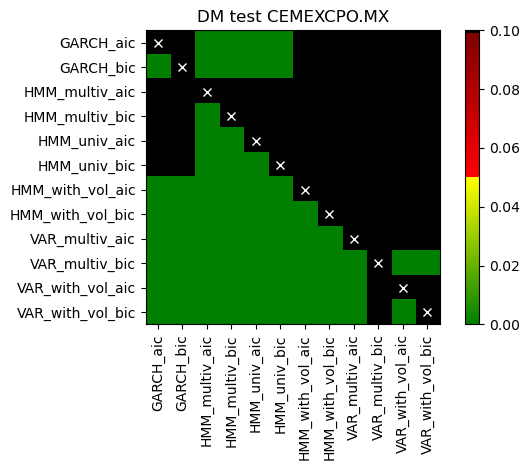

CX


c:\Users\alfredo.sampron\Documents\GitHub\regime-switching-hmm\notebooks\scripts\epftoolbox_dm_gw.py:108: RuntimeWarning: divide by zero encountered in scalar divide
  DM_stat = mean_d / np.sqrt((1 / N) * var_d)


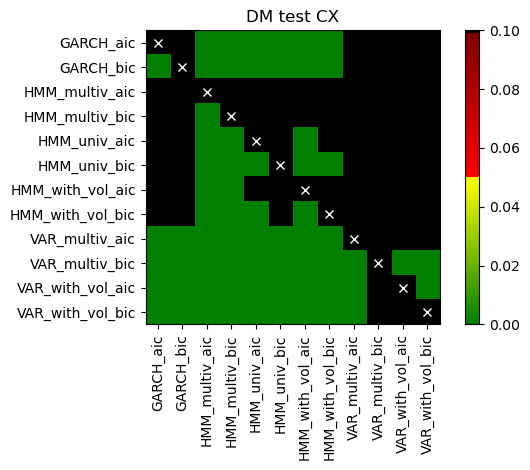

In [20]:
for stock in forecasts_by_stock.keys():
    print(stock)
    real_values=subset_of_columns(df_test, f"{stock}_log_rets")
    forecasts=delete_in_column_names(forecasts_by_stock[stock].fillna(0), f"_{stock}")   

    plot_multivariate_DM_test(real_price=real_values, 
                            forecasts=forecasts.fillna(0), 
                            title=f"DM test {stock}",
                            savefig=True,
                            path=dmroute)

In [21]:
best_models_by_stock={stock:None for stock in residuals_by_stock.keys()}

for stock, dataframe in residuals_by_stock.items():
    dataframe = delete_in_column_names(dataframe, f"_{stock}")
    metrics_df = pd.DataFrame(index=["mse", "meanabs", "medianabs"])

    for column in dataframe.columns:
        single_model=pd.DataFrame(dataframe[column])
        
        metrics_df.loc["mse", column] = (
            (single_model**2).mean().mean()
        )
        metrics_df.loc["meanabs", column] = (
            single_model.abs().mean().mean()
        )
        metrics_df.loc["medianabs", column] = (
            (single_model.abs()).median().median()
        )
    metrics_df = metrics_df * 100
    metrics_df = subset_of_columns(metrics_df, substring="", exclude="USD")
    
    best_dict={}
    for criterion in metrics_df.index:
        best_dict[criterion] = metrics_df.iloc[metrics_df.index==criterion].idxmin(axis="columns").values[0]
        
    best_models_by_stock[stock]= (metrics_df, best_dict)

In [22]:
print(params["tickerlist"][0])
best_models_by_stock[params["tickerlist"][0]][1]

^MXX


{'mse': 'VAR_multiv_aic',
 'meanabs': 'VAR_multiv_aic',
 'medianabs': 'VAR_multiv_aic'}

In [23]:
best_models_by_stock[params["tickerlist"][0]][0]

,GARCH_aic,GARCH_bic,HMM_multiv_aic,HMM_multiv_bic,HMM_univ_aic,HMM_univ_bic,HMM_with_vol_aic,HMM_with_vol_bic,VAR_multiv_aic,VAR_multiv_bic,VAR_with_vol_aic,VAR_with_vol_bic
mse,80.575441,0.008761,0.008562,0.008200,0.008685,0.008685,0.007491,0.007474,0.005900,0.007776,0.007221,0.008030
meanabs,9.138667,0.709581,0.705022,0.674079,0.709446,0.709446,0.645197,0.643113,0.603494,0.685076,0.642844,0.690120
medianabs,0.574244,0.584554,0.563449,0.516597,0.590149,0.590149,0.522079,0.489152,0.474569,0.537707,0.494502,0.563937


In [24]:
best_models_by_stock[params["tickerlist"][0]][0].rank(axis=1)

,GARCH_aic,GARCH_bic,HMM_multiv_aic,HMM_multiv_bic,HMM_univ_aic,HMM_univ_bic,HMM_with_vol_aic,HMM_with_vol_bic,VAR_multiv_aic,VAR_multiv_bic,VAR_with_vol_aic,VAR_with_vol_bic
mse,12.0,11.0,8.0,7.0,9.5,9.5,4.0,3.0,1.0,5.0,2.0,6.0
meanabs,12.0,11.0,8.0,5.0,9.5,9.5,4.0,3.0,1.0,6.0,2.0,7.0
medianabs,9.0,10.0,7.0,4.0,11.5,11.5,5.0,2.0,1.0,6.0,3.0,8.0


In [25]:
agg_df=(pd.DataFrame().reindex_like(best_models_by_stock[params["tickerlist"][0]][0]))

for asset in params["tickerlist"]:
    ranks = best_models_by_stock[asset][0].rank(axis=1)
    agg_df = agg_df.add(ranks, fill_value=0)
    
agg_df

,GARCH_aic,GARCH_bic,HMM_multiv_aic,HMM_multiv_bic,HMM_univ_aic,HMM_univ_bic,HMM_with_vol_aic,HMM_with_vol_bic,VAR_multiv_aic,VAR_multiv_bic,VAR_with_vol_aic,VAR_with_vol_bic
mse,87.5,89.5,88.0,75.0,62.0,64.0,31.0,34.0,11.0,59.0,41.0,60.0
meanabs,87.5,90.5,79.0,64.0,69.0,70.0,24.0,24.0,17.0,72.0,48.0,57.0
medianabs,78.5,79.5,61.0,53.0,64.0,70.0,26.0,18.0,55.0,79.0,55.0,63.0


In [26]:
agg_df.to_csv(os.path.join(resultsroute, f"""aggregate_results_df_{params["tablename"]}.csv"""))

In [27]:
criterion="mse"
print(f"Best overall performance by {criterion}")
agg_df.T.nsmallest(3, f"{criterion}").index.to_list()

Best overall performance by mse


['VAR_multiv_aic', 'HMM_with_vol_aic', 'HMM_with_vol_bic']